In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import PATH_MIGRATION_SPEECHES_EMBEDDED

In [3]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,party,migration_prob,jinaai/jina-embeddings-v3,jinaai/jina-embeddings-v4,Snowflake/snowflake-arctic-embed-l-v2.0,BAAI/bge-m3,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers/all-mpnet-base-v2,Qwen/Qwen3-Embedding-0.6B,google/embeddinggemma-300m
492,492,Karen Melchior,"Mr President, thank you very much to the Commi...",2024-04-24,22. Advance passenger information: enhancing a...,8,bill_26075_ID bill_26076_ID bill_26075_ID bi...,6401.0,9,False,...,ELDR/ALDE/Renew,0.393282,"[0.03173828, -0.05883789, 0.06347656, 0.061523...","[-0.017475849, -0.0234765, 0.01301684, 0.00316...","[0.029303519, 0.02908727, 0.04424794, 0.051043...","[0.00046046128, 0.041610897, -0.023090536, -0....","[0.020603927, -0.017596412, 0.0006259507, -0.0...","[0.009955298, 0.01231596, -0.031741396, 0.0164...","[-0.031322084, 0.030157333, -0.005754259, -0.0...","[-0.06368264, -0.01790871, 0.008169121, 0.0173..."
844,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,Greens/EFA,0.423501,"[0.046142578, -0.076660156, 0.03930664, -0.024...","[-0.012335925, -0.012685713, 0.007637553, 0.03...","[0.0022561324, 0.03212409, 0.01491972, 0.02270...","[-0.014090479, 0.02344181, -0.032296076, 0.005...","[-0.03277658, 0.075279415, 0.00988437, -0.0314...","[0.050362997, 0.031640317, 0.0033627285, 0.010...","[0.0490291, -0.0001613221, -0.007507243, 0.003...","[-0.06358229, 0.05332363, -0.006831329, 0.0041..."
1050,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,NGL/The Left,0.375925,"[-0.02368164, -0.11767578, 0.041503906, -0.015...","[-0.006263365, -0.0037057083, 0.003096705, 0.0...","[0.017229473, 0.052975528, 0.015071628, -0.019...","[-0.037878938, 0.04945201, -0.028479485, 0.008...","[-3.740648e-05, 0.042549398, -0.01705076, -0.0...","[-0.016886365, 0.02107416, 0.022850083, -0.003...","[0.005645505, 0.03181904, -0.0033138462, 0.033...","[-0.049918693, -0.001202861, -0.008896867, -0...."
1054,1054,Beata Kempa,Pani Przewodnicząca! Pani Komisarz! Potrzebuje...,2024-04-22,20. Amending Directive 2011/36/EU on preventin...,14,bill_241_ID bill_241_ID,6400.0,9,False,...,ECR,0.256493,"[0.028686523, -0.09667969, 0.08251953, 0.00303...","[0.0019489997, -0.00825006, 0.032056473, 0.004...","[-0.011141846, -0.009032944, -0.04128787, 0.01...","[-0.023567535, 0.005077537, -0.07184075, 0.013...","[-0.0042979075, 0.079598755, -0.070720166, -0....","[0.0069901105, -0.003832352, 0.014021035, 0.03...","[-0.04446165, 0.02761738, -0.00755511, 0.07728...","[-0.035047594, 0.03835739, -0.051198084, 0.050..."
1056,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,ECR,0.475315,"[0.02709961, -0.13085938, 0.049560547, -0.0139...","[-0.015246119, -0.009003674, 0.019220384, 0.01...","[-0.027185386, -0.015011083, 0.005534012, -0.0...","[-0.0021237587, -0.027706854, -0.04229295, 0.0...","[-0.10969446, 0.08347164, 0.015826896, -0.0843...","[0.05082612, -0.035786744, 0.014009577, 0.0413...","[-0.050546486, -0.012648543, -0.008574607, 0.0...","[-0.06766452, 0.015919995, -0.019874139, -0.01..."


In [4]:
# These are our candidate embedding models, which were chosen based on their MTEB leaderboard score [https://huggingface.co/spaces/mteb/leaderboard]
# and model size. Ideally we want an embedding model which can produce high quality semantic embeddings with limited computing power 

MODELS = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'sentence-transformers/all-mpnet-base-v2', 
           'Qwen/Qwen3-Embedding-0.6B', 'google/embeddinggemma-300m']



# Measure Group Cohesivness

Based on the notion that embedding models can catch semantic similarities well, we are assuming that speeches produced by the MEPs belonging to the same eu party should be on average more similar to each other
than to other party members' speeches.




In [5]:
# measure group similarity 
# take any model 
model = MODELS[0]

embeddings = np.stack(df[model])

In [6]:
similarities = embeddings @ embeddings.T  # (num_vector, vector_dum) x (vector_dim, num_vectors) -> (num_vectors, num_vectors)

In [7]:
vector_norms = np.linalg.vector_norm(embeddings, axis=1, ord=2)  # measure L2 norm for each vector

In [8]:
np.diag(similarities)

array([1.0054817 , 1.0008935 , 1.001339  , ..., 0.99347603, 0.9985336 ,
       0.99452424], shape=(9705,), dtype=float32)

In [9]:
# dot product should have L2 norm squared of embedding vectors as its diagonal
assert np.isclose(np.diag(similarities), np.pow(vector_norms, 2)).all()


In [10]:
# but we want our similarity score to be [0, 1] where similarity of vector to itself should be 1

assert np.isclose(np.diag(similarities), np.ones_like(np.diag(similarities))).all()

AssertionError: 

In [11]:
# so we have to compute cosine similarity instead
# normalize vectors first and then compute dot product 

normalized_embeddings = embeddings / vector_norms[:, np.newaxis]

In [12]:
# new norms should be 1
normalized_norms = np.linalg.vector_norm(normalized_embeddings, axis=1, ord=2)
assert np.isclose(normalized_norms, np.ones_like(normalized_norms)).all()

In [13]:
cosine_similarities = normalized_embeddings @ normalized_embeddings.T

In [14]:
def get_average_intra_inter_similarities(model: str, group_col: str) -> list[dict]:
    embeddings = np.stack(df[model])
    normalized_embeddings = embeddings / np.linalg.vector_norm(embeddings, axis=1, ord=2, keepdims=True)
    similarities = normalized_embeddings @ normalized_embeddings.T


    classes = df[group_col].unique()
    results = []

    for class_ in classes:
        intra = similarities[df[group_col] == class_][:, df[group_col] == class_]
        n = intra.shape[0]
        intra = intra[~np.eye(n, dtype=bool)].reshape((n, n-1)).mean()
        inter = similarities[df[group_col] == class_][:, df[group_col] != class_].mean()
        results.append({'class': class_, 'intra': intra, 'inter': inter, 'size': sum(df[group_col] == class_)})
    return results

## See if group cohesivness makes sense

In [15]:
cohesiveness = get_average_intra_inter_similarities(MODELS[0], 'party')

In [16]:
cohesiveness

[{'class': 'ELDR/ALDE/Renew',
  'intra': np.float32(0.5954139),
  'inter': np.float32(0.58829993),
  'size': 854},
 {'class': 'Greens/EFA',
  'intra': np.float32(0.6237611),
  'inter': np.float32(0.59501326),
  'size': 483},
 {'class': 'NGL/The Left',
  'intra': np.float32(0.58771133),
  'inter': np.float32(0.5807299),
  'size': 926},
 {'class': 'ECR',
  'intra': np.float32(0.5956239),
  'inter': np.float32(0.5871686),
  'size': 1029},
 {'class': 'PSE/S&D',
  'intra': np.float32(0.60686755),
  'inter': np.float32(0.5910528),
  'size': 2332},
 {'class': 'PPE',
  'intra': np.float32(0.60264784),
  'inter': np.float32(0.5883746),
  'size': 2472},
 {'class': 'ENF/ID',
  'intra': np.float32(0.58146954),
  'inter': np.float32(0.5654784),
  'size': 1176},
 {'class': 'EDD/INDDEM/EFD',
  'intra': np.float32(0.57837397),
  'inter': np.float32(0.5772771),
  'size': 433}]

Intra and inter scores are very similar for each party so the next question is 
are intraparty speeches really semantically more similar then interparty speeches>. We would like to somehow quantify our   

In [40]:
a = np.zeros((3, 3))
np.putmask(a, [[True, False, False],
                    [False, False, True],
                    [True, True, True]], 1)

In [45]:
a.sum()

np.float64(5.0)

In [46]:
a.sum(axis=1) / np.count_nonzero(a, axis=1)

array([1., 1., 1.])

In [49]:
def get_intra_inter_similarities(model: str, group_col: str) -> list[dict]:
    embeddings = np.stack(df[model])
    normalized_embeddings = embeddings / np.linalg.vector_norm(embeddings, axis=1, ord=2, keepdims=True)
    similarities = normalized_embeddings @ normalized_embeddings.T


    classes = df[group_col].unique()
    results = {"intra": [], "inter": []}

    speaker_mask = df['speaker'].apply(lambda speaker: speaker == df['speaker']).to_numpy()
    # for intra scores we want only to compare against other party members speeches
    np.putmask(similarities, speaker_mask, 0)

    for class_ in classes:
        intra = similarities[df[group_col] == class_][:, df[group_col] == class_]
        inter = similarities[df[group_col] == class_][:, df[group_col] != class_]
        results["intra"].append(intra.sum(axis=1) / np.count_nonzero(intra, axis=1))  # because 0s denote speeches coming from the same speaker
        results["inter"].append(inter.mean(axis=1))
    return np.concat(results['intra']), np.concat(results['inter'])

In [50]:
intra_sim, inter_sim = get_intra_inter_similarities(MODELS[0], 'party')

In [51]:
intra_sim.mean(), inter_sim.mean()

(np.float64(0.5973488573318285), np.float32(0.58520293))

In [52]:
y = np.linspace(0, 1, 1_000)

num_intra = len(intra_sim)
num_inter = len(inter_sim)

cdf_intra = np.array([np.sum(intra_sim <= yi) for yi in y]) / num_intra
cdf_inter = np.array([np.sum(inter_sim <= yi) for yi in y]) / num_inter

ks_statistics = np.abs(cdf_inter - cdf_intra)

y_point = ks_statistics.argmax()


In [53]:
((cdf_inter - cdf_intra).min())

np.float64(-0.00010303967027305513)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

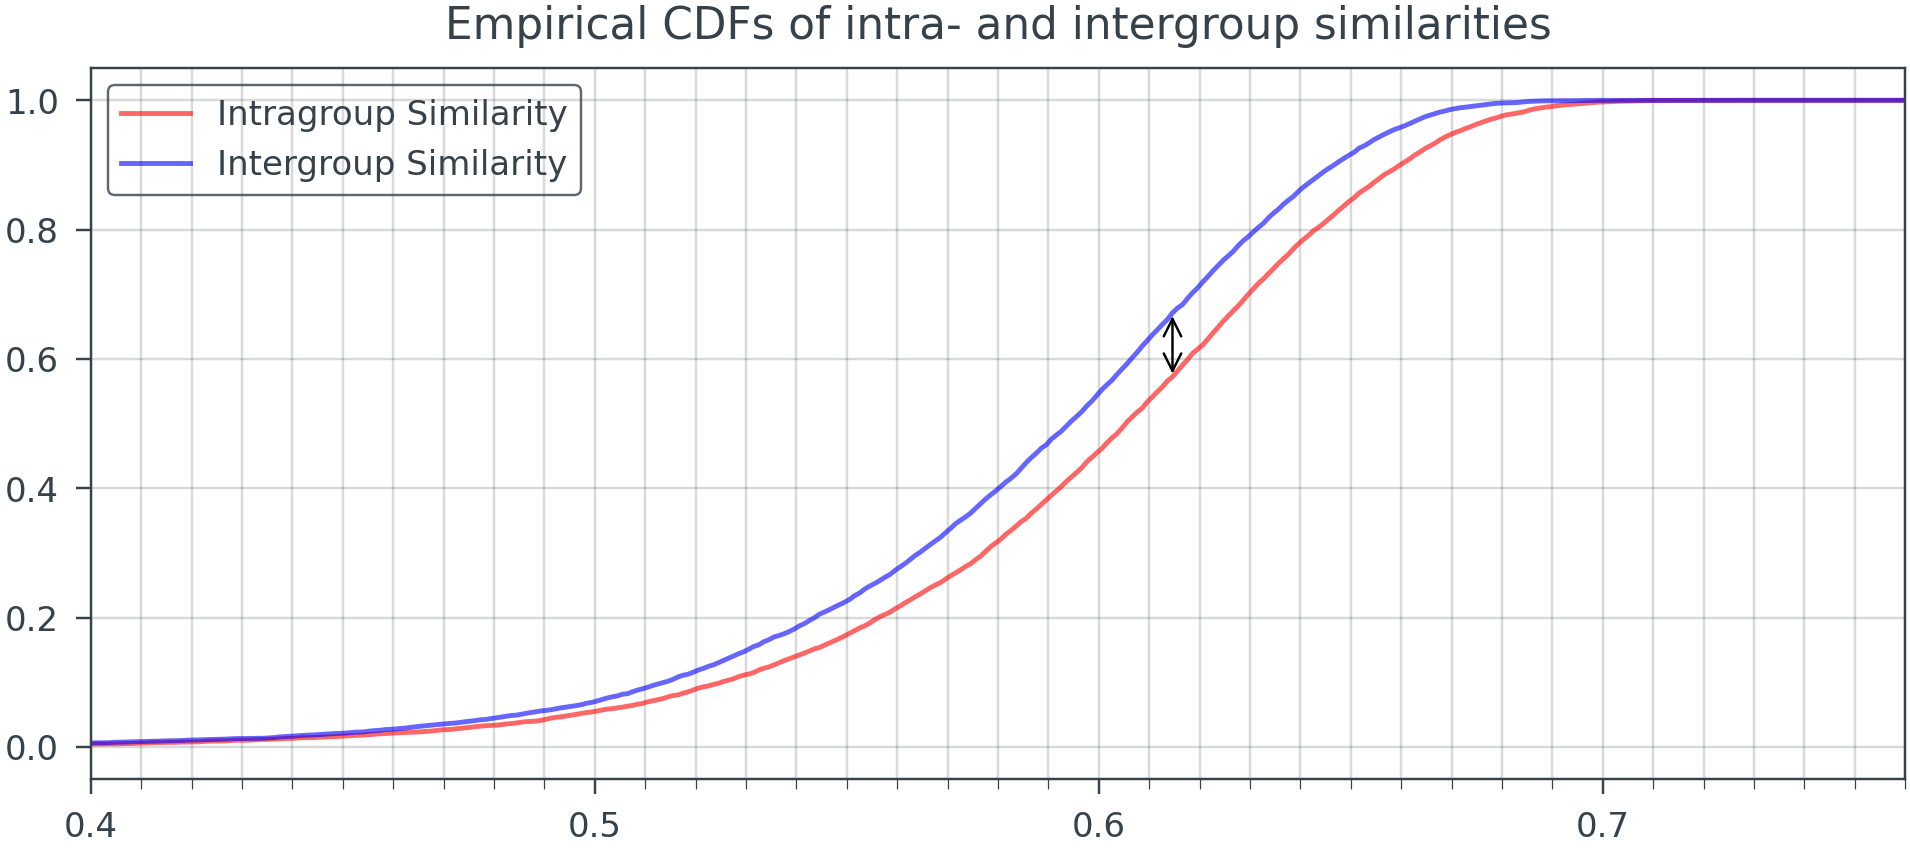

In [54]:
fig, ax  = plt.subplots()

plt.title("Empirical CDFs of intra- and intergroup similarities")

ax.xaxis.set_major_locator(plt.MultipleLocator(.1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(.01))

ax.plot(y, cdf_intra, color="red", alpha=.6, label="Intragroup Similarity")
ax.plot(y, cdf_inter, color="blue", alpha=.6, label="Intergroup Similarity")

ax.annotate("", xytext=(y[y_point], cdf_inter[y_point] + 0.01), xy=(y[y_point], cdf_intra[y_point] - 0.01),
            arrowprops=dict(arrowstyle="<->"))

ax.set_xlim(0.4, 0.76)
ax.grid(which="both")
ax.legend()

In [29]:
from scipy import stats
from tqdm import tqdm

# Take inter_sim >= intra_sim as our null hypothesis and compute ks on every embedding model
# are semantically closer
p_values = []
for model in tqdm(MODELS):
    intra_sim, inter_sim = get_intra_inter_similarities(model, 'party')
    d, p_value = stats.ks_2samp(intra_sim, inter_sim, alternative="greater")
    p_values.append(p_value)


100%|██████████| 8/8 [01:21<00:00, 10.25s/it]


In [28]:
sum(p_values)

np.float64(1.992043721444669e-46)

sum of p values is very low meaning we have sufficient evidence to reject our null hypothesis and assume that intra group speeches are more similar

## Compute for all embedding models

In [30]:
def get_cohesiveness(model: str, group_col: str) -> float:
    similarities = get_average_intra_inter_similarities(model=model, group_col=group_col)
    size = sum(sim['size'] for sim in similarities)
    cohesivness = sum((sim['intra'] / sim['inter'] - 1) * sim['size'] for sim in similarities) / size
    return cohesivness.item()

In [31]:
for model in MODELS:
    print(model, get_cohesiveness(model, 'party'))

jinaai/jina-embeddings-v3 0.022262409329414368
jinaai/jina-embeddings-v4 0.014088530093431473
Snowflake/snowflake-arctic-embed-l-v2.0 0.030278660356998444
BAAI/bge-m3 0.014755720272660255
sentence-transformers/all-MiniLM-L6-v2 0.10594873875379562
sentence-transformers/all-mpnet-base-v2 0.062429193407297134
Qwen/Qwen3-Embedding-0.6B 0.033938683569431305
google/embeddinggemma-300m 0.045885615050792694


Based on Group Cohesivness miniLM, mpnet and google embeddings are most promising. 